In [1]:
import pandas as pd
import numpy as np
import json
import re
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


Bad key text.latex.preview in file /Users/vorsi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/vorsi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/vorsi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the de

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import sklearn
#from sklearn import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.tokenize import TweetTokenizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import joblib
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.layers import Flatten
#from keras.metrics import *
#import keras

In [4]:
from sklearn.inspection import permutation_importance
import rfpimp
#from eli5.sklearn import PermutationImportance

In [5]:
import pandas as pd

In [6]:
%matplotlib inline

In [7]:
p_in="/Users/vorsi/Dropbox/bot and agenda-setting/codes and data/bot_identification_code_and_data/"

In [8]:
#pd.read_json(p_in+"training_set/Twibot-20/dev.json")

### Data preprocessing

In [ ]:
# Reading in json training set & data preprocessing
def json_unifier(file_path, is_bot = None):
    with open(file_path) as f:
        file = json.loads(f.read())
        key_to_extract = list(file[0].keys())[1]
        user_dict_list = [i[key_to_extract] for i in file]
    df = pd.DataFrame(user_dict_list)
    if is_bot is not None:
        df['is_bot'] = is_bot
    elif file_path != "./training_set/Twibot-20/train.json":
        identification_path = file_path.replace("_tweets.json", ".tsv")
        tag_df = pd.read_csv(identification_path, sep='\t', names = ['id','is_bot'])
        tag_df['is_bot'] = [1.0 if i == "bot" else 0.0 for i in list(tag_df['is_bot'])]
        df = pd.merge(df,tag_df,left_on='id',right_on='id', copy = False, suffixes=(None, '_y'))
        #df['is_bot'] = df["is_bot_y"]
        #df.drop(labels = ["id_y", "is_bot_y"], axis = 1)
        #print(df)
    else:
        with open(file_path) as f:
            file = json.loads(f.read())
            key_to_extract_new = list(file[0].keys())[5]
            is_bot = [int(i[key_to_extract_new]) for i in file]
        df['is_bot'] = is_bot
    return df

training_set_paths = {p_in+"training_set/Twibot-20/train.json":None,
                     p_in+"training_set/verified-2019_tweets.json":0,
                     p_in+"training_set/vendor-purchased-2019_tweets.json":1,
                     p_in+"training_set/political-bots-2019_tweets.json":1,
                     p_in+"training_set/cresci-rtbust-2019_tweets.json":None,
                      p_in+"training_set/botometer-feedback-2019_tweets.json":None,
                     p_in+"training_set/botwiki-2019/botwiki-2019_tweets.json":1
                     }
all_df = pd.DataFrame()
for file,is_bot in training_set_paths.items():
    #print(is_bot)
    training_df = json_unifier(file, is_bot)
    all_df = pd.concat([all_df, pd.DataFrame([training_df])], ignore_index=True)
    #all_df = all_df.append(training_df,ignore_index = True)


In [11]:
training_df

,id,id_str,name,screen_name,location,profile_location,description,url,entities,protected,...,profile_image_url_https,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,is_bot


In [48]:
file_path = "./training_set/Twibot-20/train.json"
is_bot = None

In [49]:
# read in csv files
delete_list = ['timestamp', 'crawled_at', 'updated', 'test_set_1','test_set_2']
def csv_unifier(file_path, is_bot = None):
    df = pd.read_csv(file_path)
    column_list = list(df.columns)
    column_list = [i for i in column_list if i not in delete_list]
    df = df[column_list]
    if is_bot is not None:
        df['is_bot'] = is_bot
    return df

csv_set_paths = {"./training_set/users_real.csv":0,
            "./training_set/users.csv":1,
            "./training_set/users_fake_follower.csv":1,
                 "./training_set/users_socialbot.csv":1
                }
for file, is_bot in csv_set_paths.items():
    training_df = csv_unifier(file, is_bot)
    all_df = all_df.append(training_df, ignore_index = True)


In [51]:
all_df.tail()

,id,id_str,name,screen_name,location,profile_location,description,url,entities,protected,...,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,is_bot,profile_banner_url,following,follow_request_sent,notifications,translator_type
16315,2349367388,NaN,Ruby Porchia,RubyPorchia,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
16316,2391867347,NaN,Masud Thomas,MasudThomas,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,1.0,NaN,1.0,https://pbs.twimg.com/profile_banners/23918673...,NaN,NaN,NaN,NaN
16317,2357512092,NaN,Rhonda Hoes,RhondaHoes,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
16318,2349689623,NaN,Mae Asif,MaeAsif,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
16319,2357961930,NaN,Yvonne Harpel,YvonneHarpel,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [52]:
def generate_features(all_df, create_param = 'created_at'):
    created_at_dt = pd.to_datetime(all_df[create_param], format = "%a %b %d %H:%M:%S +0000 %Y ", errors = 'coerce')
    created_at_dt_new = pd.to_datetime(all_df[create_param], format = "%a %b %d %H:%M:%S +0000 %Y", errors = 'coerce')
    created_at_dt = [created_at_dt_new[i] if pd.isnull(created_at_dt[i]) else created_at_dt[i] for i in range(len(created_at_dt))]
    all_df['created_at_dt'] = created_at_dt
    all_df['user_age'] = [datetime.now() - i for i in all_df['created_at_dt']]
    all_df['user_age'] = [i.total_seconds()//3600 for i in all_df['user_age']]
    main_traits = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count']
    derived_traits = ['tweet_freq','followers_growth','friends_growth', 'favourites_growth', 'listed_growth']

    for i in range(5):
        all_df[main_traits[i]] = [int(k) for k in all_df[main_traits[i]]]
        all_df[derived_traits[i]] = all_df[main_traits[i]]/all_df['user_age']

    all_df['follower_friend_ratio'] = all_df['followers_count']/(all_df['friends_count'] + 1)
    all_df['screen_name_length'] = [len(i) for i in all_df['screen_name']]
    all_df['digits_in_screen_name'] = [sum(c.isdigit() for c in i) for i in all_df['screen_name']]
    all_df['name_length'] = [len(i) if pd.notnull(i) else 0 for i in all_df['name']]
    all_df['digits_in_name'] = [sum(c.isdigit() for c in i) if pd.notnull(i) else 0 for i in all_df['name']]
    all_df['description_length'] = [len(i) if pd.notnull(i) else 0 for i in all_df['description']]
    return all_df

In [53]:
all_df = generate_features(all_df)

In [54]:
all_df.tail()

,id,id_str,name,screen_name,location,profile_location,description,url,entities,protected,...,followers_growth,friends_growth,favourites_growth,listed_growth,follower_friend_ratio,screen_name_length,digits_in_screen_name,name_length,digits_in_name,description_length
16315,2349367388,NaN,Ruby Porchia,RubyPorchia,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000730,0.006968,0.000000,0.0,0.104610,11,0,12,0,0
16316,2391867347,NaN,Masud Thomas,MasudThomas,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000075,0.000324,0.000324,0.0,0.222222,11,0,12,0,0
16317,2357512092,NaN,Rhonda Hoes,RhondaHoes,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000050,0.000409,0.000000,0.0,0.117647,10,0,11,0,0
16318,2349689623,NaN,Mae Asif,MaeAsif,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001300,0.009692,0.000000,0.0,0.133929,7,0,8,0,0
16319,2357961930,NaN,Yvonne Harpel,YvonneHarpel,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000074,0.000372,0.000000,0.0,0.193548,12,0,13,0,0


In [55]:
len(all_df)

16320

In [57]:
# I have much smaller sample Counter({0.0: 9813, 1.0: 14785})

In [56]:
from collections import Counter
Counter(all_df.is_bot)

Counter({0.0: 6181, 1.0: 10139})

In [58]:
all_df['user_age'] = [datetime.now() - i for i in all_df['created_at_dt']]
all_df['user_age'] = [i.total_seconds()//3600 for i in all_df['user_age']]
main_traits = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count']
derived_traits = ['tweet_freq','followers_growth','friends_growth', 'favourites_growth', 'listed_growth']

for i in range(5):
    all_df[main_traits[i]] = [int(k) for k in all_df[main_traits[i]]]
    all_df[derived_traits[i]] = all_df[main_traits[i]]/all_df['user_age']

all_df['follower_friend_ratio'] = all_df['followers_count']/(all_df['friends_count'] + 1)
all_df['screen_name_length'] = [len(i) for i in all_df['screen_name']]
all_df['digits_in_screen_name'] = [sum(c.isdigit() for c in i) for i in all_df['screen_name']]
all_df['name_length'] = [len(i) if pd.notnull(i) else 0 for i in all_df['name']]
all_df['digits_in_name'] = [sum(c.isdigit() for c in i) if pd.notnull(i) else 0 for i in all_df['name']]
all_df['description_length'] = [len(i) if pd.notnull(i) else 0 for i in all_df['description']]

In [61]:
# (1) statuses count; (2) followers count; (3)
#friends count; (4) favorites count; (5) listed count; (6) default profile; (7) geo enabled; (8) profile
#use background image; (9) protected; and (10) verified. 

def get_train_test(df, test_size = 0.3, random_state = 15):
    features = ['statuses_count', 'followers_count', "friends_count", "favourites_count","listed_count","default_profile",
               "geo_enabled","profile_use_background_image",
                "protected", 
                "verified",'tweet_freq','followers_growth','friends_growth', 'favourites_growth', 'listed_growth',
               'follower_friend_ratio', 'screen_name_length','digits_in_screen_name', 
               'name_length','digits_in_name', 'description_length']

    boolean_features = ["default_profile","geo_enabled","profile_use_background_image", "verified",
                       "protected"]
    #boolean_features = ["protected", "verified"]
    x_df = df[features]
    x_df = x_df.fillna(0.0)
    x_df[boolean_features] = x_df[boolean_features].replace("True ",1.0)
    x_df[boolean_features] = x_df[boolean_features].replace("False ",0.0)
    x_df = x_df.apply(lambda x: np.asarray(x).astype(np.float32))

    y_df = df['is_bot']
    xtrain, xtest, ytrain, ytest = train_test_split(x_df, y_df, test_size = test_size, random_state = random_state)
    return xtrain, xtest, ytrain, ytest

xtrain, xtest, ytrain, ytest = get_train_test(all_df)

### Random forest

In [62]:
# baseline: botometre
rf_cols = ['statuses_count', 'followers_count', "friends_count", "favourites_count","listed_count","default_profile",
               "geo_enabled","profile_use_background_image",
                "protected", 
                "verified"]
xtest_rf = xtest[rf_cols]
xtrain_rf = xtrain[rf_cols]




In [63]:
rf_test1 = {'n_estimators':[i for i in range(10,201,10)]}
rf_search1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = rf_test1, scoring='roc_auc',cv=5)
rf_search1.fit(xtrain_rf,ytrain)
rf_search1.cv_results_


{'mean_fit_time': array([0.05300808, 0.08923326, 0.13575034, 0.18153634, 0.22461839,
        0.26874599, 0.31118498, 0.35676079, 0.41541119, 0.45889173,
        0.52248511, 0.55381255, 0.59849977, 0.63970041, 0.67401924,
        0.71230631, 0.75367522, 0.81176219, 0.8491365 , 0.88966403]),
 'std_fit_time': array([0.01506395, 0.0005969 , 0.00032709, 0.00269403, 0.00265822,
        0.00216264, 0.00061259, 0.00159313, 0.00895157, 0.00751322,
        0.02569117, 0.03450274, 0.00928209, 0.00946574, 0.00672229,
        0.00207016, 0.0058659 , 0.0149461 , 0.00289588, 0.00645145]),
 'mean_score_time': array([0.00398693, 0.00498648, 0.00688887, 0.00847373, 0.00978703,
        0.01142259, 0.01285887, 0.01456461, 0.01666369, 0.01829424,
        0.02043915, 0.02131963, 0.02450638, 0.02569923, 0.02603154,
        0.02740645, 0.02912455, 0.03077192, 0.03247037, 0.03373771]),
 'std_score_time': array([1.13301039e-03, 2.31810548e-05, 8.19694032e-05, 2.18358235e-04,
        1.20404961e-04, 1.19654720e-

In [65]:
#RandomForestClassifier(max_depth=8, min_samples_split=100, n_estimators=180,
#                       random_state=10)

rf_search1.best_estimator_

RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_split=100,
                       n_estimators=150, random_state=10)

In [55]:
rf_search1.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_split=100, n_estimators=180,
                       random_state=10)

In [71]:
rf_search1.best_estimator_

RandomForestClassifier(max_depth=18, max_features='sqrt', min_samples_split=100,
                       n_estimators=150, random_state=10)

In [72]:
# Random forest
forest = RandomForestClassifier(n_estimators=150,max_depth=18, max_features='sqrt' ,random_state=10)
forest.fit(xtrain,ytrain)
forest_result = list(forest.predict(xtest))

In [73]:
print(sklearn.metrics.classification_report(ytest, forest_result))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1838
         1.0       0.97      0.96      0.97      3058

    accuracy                           0.96      4896
   macro avg       0.95      0.96      0.95      4896
weighted avg       0.96      0.96      0.96      4896



In [23]:
#print(sklearn.metrics.classification_report(ytest, forest_result))

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      2886
         1.0       0.89      0.90      0.89      4494

    accuracy                           0.87      7380
   macro avg       0.86      0.86      0.86      7380
weighted avg       0.87      0.87      0.87      7380



In [74]:
forest_10 = RandomForestClassifier(n_estimators=150,max_depth=18, max_features='sqrt' ,random_state=10)
forest_10.fit(xtrain_rf,ytrain)
forest_10_result = list(forest_10.predict(xtest_rf))

In [75]:
print(sklearn.metrics.classification_report(ytest, forest_10_result))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      1838
         1.0       0.97      0.96      0.96      3058

    accuracy                           0.96      4896
   macro avg       0.95      0.96      0.95      4896
weighted avg       0.96      0.96      0.96      4896



In [25]:
print(sklearn.metrics.classification_report(ytest, forest_10_result))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82      2886
         1.0       0.87      0.91      0.89      4494

    accuracy                           0.86      7380
   macro avg       0.86      0.85      0.85      7380
weighted avg       0.86      0.86      0.86      7380



In [76]:
lr_probs = forest.predict_proba(xtest_rf)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(list(ytest), lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(list(ytest), lr_probs)
plt.plot(lr_fpr, lr_tpr)

ValueError: X has 10 features, but DecisionTreeClassifier is expecting 21 features as input.

In [77]:
# Logistic regression
logit = LogisticRegression()
logit.fit(xtrain_rf,ytrain)
logit_result = list(logit.predict(xtest_rf))

In [78]:
print(sklearn.metrics.classification_report(ytest,logit_result))

              precision    recall  f1-score   support

         0.0       0.91      0.45      0.60      1838
         1.0       0.75      0.97      0.85      3058

    accuracy                           0.78      4896
   macro avg       0.83      0.71      0.72      4896
weighted avg       0.81      0.78      0.75      4896



In [67]:
joblib.dump(forest, 'random_forest_model_20trait.joblib') 
joblib.dump(forest_10, 'random_forest_model_20trait.joblib') 

['random_forest_model_122022.joblib']

In [77]:
#Visualization of metrics
# accuracy, percision, recall, f1, sensivity, specificity
forest_metric = sklearn.metrics.classification_report(ytest, forest_result,output_dict=True)
svm_metric = sklearn.metrics.classification_report(ytest,svm_result,output_dict=True)
logit_metric = sklearn.metrics.classification_report(ytest,logit_result,output_dict=True)


In [78]:
print(forest_metric)
print(svm_metric)
print(logit_metric)

{'0.0': {'precision': 0.8392031305585201, 'recall': 0.8173943173943174, 'f1-score': 0.8281551693873969, 'support': 2886}, '1.0': {'precision': 0.884657474283213, 'recall': 0.89942145082332, 'f1-score': 0.8919783736069734, 'support': 4494}, 'accuracy': 0.8673441734417344, 'macro avg': {'precision': 0.8619303024208665, 'recall': 0.8584078841088187, 'f1-score': 0.8600667714971851, 'support': 7380}, 'weighted avg': {'precision': 0.8668822390542884, 'recall': 0.8673441734417344, 'f1-score': 0.8670198685422448, 'support': 7380}}
{'0.0': {'precision': 0.797377830750894, 'recall': 0.6954261954261954, 'f1-score': 0.7429205996668518, 'support': 2886}, '1.0': {'precision': 0.8192473781616286, 'recall': 0.8865153538050734, 'f1-score': 0.8515549855722989, 'support': 4494}, 'accuracy': 0.8117886178861788, 'macro avg': {'precision': 0.8083126044562613, 'recall': 0.7909707746156345, 'f1-score': 0.7972377926195753, 'support': 7380}, 'weighted avg': {'precision': 0.8106951405156422, 'recall': 0.81178861

In [79]:
method = ['RF',"SVM","LOGR"]
df_metric = pd.DataFrame()
for index, metrics in enumerate([forest_metric, svm_metric, logit_metric]):
    df = pd.DataFrame(metrics).transpose()
    df_temp = pd.DataFrame()
    df_temp["value"] = df['recall'].iloc[:4]
    df_temp['metric'] = ['Specificity','Sensitivity','Balanced Accuracy','Accuracy']
    df_temp = df_temp.append({"metric":"F1", "value": float(df.iloc[4,2])}, ignore_index = True)
    df_temp['method'] = method[index]
    df_metric = df_metric.append(df_temp, ignore_index = True)

/tmp/ipykernel_30041/1532899490.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append({"metric":"F1", "value": float(df.iloc[4,2])}, ignore_index = True)
/tmp/ipykernel_30041/1532899490.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metric = df_metric.append(df_temp, ignore_index = True)
/tmp/ipykernel_30041/1532899490.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append({"metric":"F1", "value": float(df.iloc[4,2])}, ignore_index = True)
/tmp/ipykernel_30041/1532899490.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metric = df_metric.append(df_temp, ignore_index = True)
/t

In [80]:
df_metric

,value,metric,method
0,0.817394,Specificity,RF
1,0.899421,Sensitivity,RF
2,0.867344,Balanced Accuracy,RF
3,0.858408,Accuracy,RF
4,0.867020,F1,RF
5,0.695426,Specificity,SVM
6,0.886515,Sensitivity,SVM
7,0.811789,Balanced Accuracy,SVM
8,0.790971,Accuracy,SVM
9,0.809073,F1,SVM


In [65]:
dl_metric = pd.DataFrame({"metric": ['Specificity','Sensitivity','Balanced Accuracy','Accuracy','F1'],
                         "value":[0.8954,0.8529,0.8911,0.7718, 0.8719]}) # This was what I had before 
dl_metric['method'] = 'DL'
df_metric = df_metric.append(dl_metric, ignore_index = True)

/tmp/ipykernel_278096/807567723.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metric = df_metric.append(dl_metric, ignore_index = True)


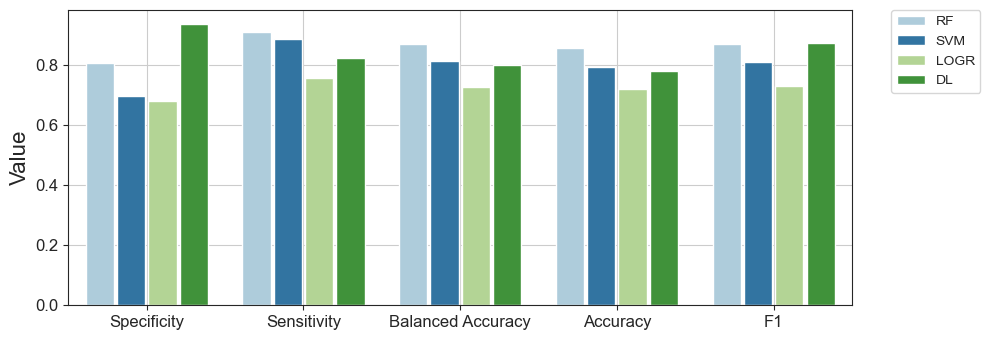

In [66]:
sns.set_style("ticks")

plt.figure(figsize=(10, 3.5))
ax = sns.barplot(data=df_metric, x='metric', y='value', hue='method',palette=("Paired"))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .18)

plt.xlabel("")
plt.ylabel("Value",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
#plt.show()
#plt.savefig("metric_comparsion_updated_20.png")

### Testing

In [51]:
#Validating with other training sets
def json_unifier(file_path, is_bot = None):
    with open(file_path) as f:
        file = json.loads(f.read())
    df = pd.DataFrame(file)
    #print(df)
    identification_path = file_path.replace("_tweets.json", ".tsv")
    tag_df = pd.read_csv(identification_path, sep='\t', names = ['id','is_bot'])
    tag_df['is_bot'] = [1.0 if i == "bot" else 0.0 for i in list(tag_df['is_bot'])]
    df = pd.merge(df,tag_df,left_on='user_id',right_on='id', copy = False, suffixes=(None, '_y'))
        #df['is_bot'] = df["is_bot_y"]
        #df.drop(labels = ["id_y", "is_bot_y"], axis = 1)
        #print(df)
    return df


In [54]:
Counter(midterm_df.is_bot)

Counter({0.0: 8092, 1.0: 42446})

In [13]:
midterm_df = json_unifier("./training_set/midterm-2018/midterm-2018_tweets.json")
midterm_df

JSONDecodeError: Extra data: line 1 column 12 (char 11)

In [55]:
midterm_df = json_unifier("./training_set/midterm-2018/midterm-2018_tweets.json")
midterm_df = generate_features(midterm_df, 'user_created_at')
xtrain_us, xtest_us, ytrain_us, ytest_us = get_train_test(midterm_df,test_size = 0.3)

In [56]:
len(midterm_df[midterm_df.is_bot==0])

8092

In [57]:
forest_result_us = list(forest.predict(xtrain_us))

In [122]:
len([i for i in ytrain_us if i == 0])

5624

In [123]:
len([i for i in forest_result_us if i == 1])

34383

In [124]:
print(sklearn.metrics.classification_report(ytrain_us, forest_result_us))

              precision    recall  f1-score   support

         0.0       0.99      0.17      0.30      5624
         1.0       0.86      1.00      0.93     29752

    accuracy                           0.87     35376
   macro avg       0.93      0.59      0.61     35376
weighted avg       0.88      0.87      0.83     35376



In [58]:
model_new.evaluate(xtrain_us, ytrain_us, batch_size = 64)

553/553 [==============================] - 1s 2ms/step - loss: 0.4431 - accuracy: 0.8910 - recall: 0.8997 - precision: 0.9684 - specificity_at_sensitivity: 0.8547 - sensitivity_at_specificity: 0.9117


[0.44305935502052307,
 0.8909995555877686,
 0.8997378349304199,
 0.9684176445007324,
 0.8547297120094299,
 0.9116697907447815]

In [126]:
print(0.8492*0.9767*2/(0.8492+0.9767))

0.9084984281724081


In [127]:
us_metric = pd.DataFrame({"metric": ['Specificity','Sensitivity','Precision','Balanced Accuracy','Accuracy','F1'],
                         "value":[0.93,0.85,0.98, 0.83,0.91, 0.88]})
us_metric_rf = pd.DataFrame({"metric": ['Specificity','Sensitivity','Precision','Balanced Accuracy','Accuracy','F1'],
                         "value":[0.89,0.93,0.97, 0.86,0.86,0.90]})
us_metric['method'] = 'RF'
us_metric_rf['method'] = 'DL'
us_metric = us_metric.append(us_metric_rf, ignore_index = True)

/tmp/ipykernel_30041/534129661.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  us_metric = us_metric.append(us_metric_rf, ignore_index = True)


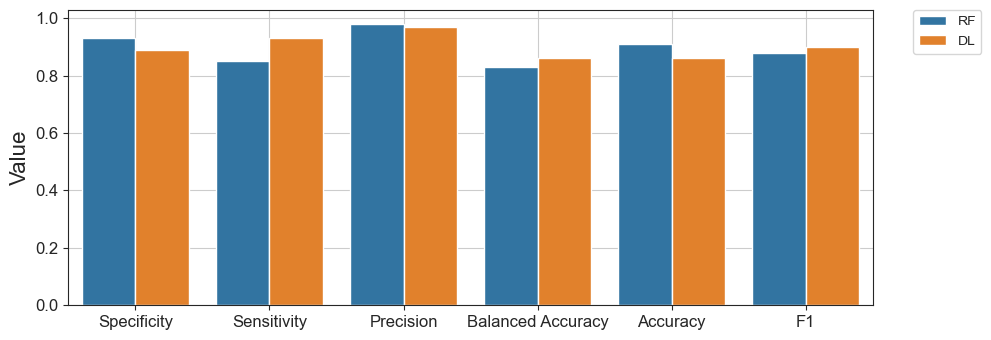

In [128]:
sns.set_style("ticks")

plt.figure(figsize=(10, 3.5))
ax = sns.barplot(data=us_metric, x='metric', y='value', hue='method')



plt.xlabel("")
plt.ylabel("Value",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("metric_comparsion_rf_dl_updated.png")

In [74]:
def json_unifier(file_path, is_bot = None):
    with open(file_path) as f:
        file = json.loads(f.read())
        key_to_extract = list(file[0].keys())[1]
        user_dict_list = [i[key_to_extract] for i in file]
    df = pd.DataFrame(user_dict_list)

    with open(file_path) as f:
        file = json.loads(f.read())
        key_to_extract_new = list(file[0].keys())[5]
        is_bot = [int(i[key_to_extract_new]) for i in file]
    df['is_bot'] = is_bot
    return df

In [75]:
testing_df = json_unifier("./training_set/Twibot-20/test.json")

In [76]:
xtrain_twi, xtest_twi, ytrain_twi, ytest_twi = get_train_test(midterm_df,test_size = 0.01)

In [77]:
forest_result_twi = list(forest.predict(xtrain_twi))
print(sklearn.metrics.classification_report(ytrain_twi, forest_result_twi))

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72      8018
         1.0       0.94      0.96      0.95     42014

    accuracy                           0.92     50032
   macro avg       0.85      0.83      0.84     50032
weighted avg       0.91      0.92      0.91     50032



In [83]:
model.evaluate(xtrain_twi, ytrain_twi, batch_size = 128)

391/391 [==============================] - 1s 1ms/step - loss: 0.3789 - accuracy: 0.8930 - precision: 0.9790 - recall: 0.8917 - specificity_at_sensitivity_6: 0.9017 - sensitivity_at_specificity_6: 0.8983


[0.37885841727256775,
 0.892968475818634,
 0.9789646863937378,
 0.8917027711868286,
 0.9017211198806763,
 0.8982719779014587]